In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Then unzip the dataset
!unzip '/content/drive/MyDrive/music_genre_data_di.zip' -d '/content/data'


Mounted at /content/drive
Archive:  /content/drive/MyDrive/music_genre_data_di.zip
   creating: /content/data/music_genre_data_di/
  inflating: /content/data/music_genre_data_di/.DS_Store  
  inflating: /content/data/__MACOSX/music_genre_data_di/._.DS_Store  
   creating: /content/data/music_genre_data_di/test/
   creating: /content/data/music_genre_data_di/train/
   creating: /content/data/music_genre_data_di/val/
  inflating: /content/data/music_genre_data_di/test/.DS_Store  
  inflating: /content/data/__MACOSX/music_genre_data_di/test/._.DS_Store  
   creating: /content/data/music_genre_data_di/test/melgrams/
   creating: /content/data/music_genre_data_di/test/pyaudioanalysis/
   creating: /content/data/music_genre_data_di/train/melgrams/
   creating: /content/data/music_genre_data_di/train/pyaudioanalysis/
   creating: /content/data/music_genre_data_di/val/melgrams/
   creating: /content/data/music_genre_data_di/val/pyaudioanalysis/
  inflating: /content/data/music_genre_data_di/te

In [2]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader,TensorDataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import torch.optim as optim
import torch.nn.functional as F
import time
import random
import pandas as pd
import copy

import torch.nn as nn


import os
import librosa




In [3]:
SEED = 42  # You can choose any integer you like

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if you are using multi-GPU

np.random.seed(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# FNN 1.1

In [4]:

# Load the data
X_train = np.load('/content/data/music_genre_data_di/train/pyaudioanalysis/X.npy')
y_train = np.load('/content/data//music_genre_data_di/train/pyaudioanalysis/labels.npy')

X_val = np.load('/content/data//music_genre_data_di/val/pyaudioanalysis/X.npy')
y_val = np.load('/content/data//music_genre_data_di/val/pyaudioanalysis/labels.npy')

X_test = np.load('/content/data//music_genre_data_di/test/pyaudioanalysis/X.npy')
y_test = np.load('/content/data//music_genre_data_di/test/pyaudioanalysis/labels.npy')




# Encode string labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(y_train)  # Fit only on training data

y_train_enc = label_encoder.transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

# Save label mapping
label_to_int = {label: idx for idx, label in enumerate(label_encoder.classes_)}
int_to_label = {idx: label for label, idx in label_to_int.items()}

print(int_to_label)
print(label_to_int)


{0: np.str_('blues'), 1: np.str_('classical'), 2: np.str_('hiphop'), 3: np.str_('rock_metal_hardrock')}
{np.str_('blues'): 0, np.str_('classical'): 1, np.str_('hiphop'): 2, np.str_('rock_metal_hardrock'): 3}


# FNN 1.2

In [5]:

class MFFCDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Wrap datasets
train_dataset = MFFCDataset(X_train, y_train_enc)
val_dataset = MFFCDataset(X_val, y_val_enc)
test_dataset = MFFCDataset(X_test, y_test_enc)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,num_workers=2,worker_init_fn=seed_worker,generator=g)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True,num_workers=2,worker_init_fn=seed_worker,generator=g)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False,num_workers=2,worker_init_fn=seed_worker,generator=g)


In [6]:


class GenreClassifierFCN(nn.Module):
    def __init__(self, input_dim=26, hidden_dims=[128, 32], output_dim=4):
        super(GenreClassifierFCN, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dims[0])  # 26 -> 128
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])  # 128 -> 32
        self.fc3 = nn.Linear(hidden_dims[1], output_dim)  # 32 -> 4

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)  # no activation
        return x  # logits (raw output for CrossEntropyLoss)


# FNN 1.3 & 1.4

In [7]:


def train_model(epochs, model, optimizer, dataloader, criterion,device):
    model.train()  # Set model to training mode

    for epoch in range(epochs):
        total_loss = 0.0

        for batch_inputs, batch_labels in dataloader:
            # Move data to the same device as the model
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass: compute predictions
            outputs = model(batch_inputs)

            # Compute loss
            loss = criterion(outputs, batch_labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

    return model


def evaluate_model(model, dataloader, criterion,device):
    model.eval()  # Set model to evaluation mode

    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for batch_inputs, batch_labels in dataloader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    # Compute metrics
    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return avg_loss, acc, f1, conf_matrix


In [8]:
import torch
print(torch.cuda.is_available())


True


# FNN 1.5 & 1.6

In [9]:


# Define training function with device specification
def train_and_evaluate(device):
    print(f"Training on: {device}")
    model = GenreClassifierFCN().to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.002)

    start_time = time.time()

    trained_model = train_model(
        epochs=30,
        model=model,
        optimizer=optimizer,
        dataloader=train_loader,
        criterion=criterion,
        device=device  # Assuming your train_model uses device properly
    )

    end_time = time.time()

    training_time = end_time - start_time
    print(f"Training time on {device}: {training_time:.2f} seconds")

    val_loss, val_acc, val_f1, val_conf = evaluate_model(model, val_loader, criterion, device=device)

    print("\nValidation Results")
    print(f"Loss       : {val_loss:.4f}")
    print(f"Accuracy   : {val_acc:.4f}")
    print(f"F1 (macro) : {val_f1:.4f}")
    print("Confusion Matrix:\n", val_conf)

    return training_time

# Check if CUDA is available
device_cpu = torch.device("cpu")
device_gpu = torch.device("cuda") if torch.cuda.is_available() else None

# Train and evaluate on CPU
time_cpu = train_and_evaluate(device_cpu)

# Train and evaluate on GPU (if available)
if device_gpu:
    time_gpu = train_and_evaluate(device_gpu)
    print("\n--- Performance Comparison ---")
    print(f"CPU Time: {time_cpu:.2f} seconds")
    print(f"GPU Time: {time_gpu:.2f} seconds")
else:
    print("\nGPU not available.")





Training on: cpu
Epoch [1/30] - Loss: 1.4074
Epoch [2/30] - Loss: 1.3727
Epoch [3/30] - Loss: 1.3537
Epoch [4/30] - Loss: 1.3363
Epoch [5/30] - Loss: 1.3126
Epoch [6/30] - Loss: 1.2886
Epoch [7/30] - Loss: 1.2660
Epoch [8/30] - Loss: 1.2416
Epoch [9/30] - Loss: 1.2118
Epoch [10/30] - Loss: 1.1877
Epoch [11/30] - Loss: 1.1577
Epoch [12/30] - Loss: 1.1335
Epoch [13/30] - Loss: 1.1146
Epoch [14/30] - Loss: 1.0891
Epoch [15/30] - Loss: 1.0644
Epoch [16/30] - Loss: 1.0486
Epoch [17/30] - Loss: 1.0328
Epoch [18/30] - Loss: 1.0200
Epoch [19/30] - Loss: 1.0052
Epoch [20/30] - Loss: 0.9928
Epoch [21/30] - Loss: 0.9827
Epoch [22/30] - Loss: 0.9745
Epoch [23/30] - Loss: 0.9706
Epoch [24/30] - Loss: 0.9582
Epoch [25/30] - Loss: 0.9536
Epoch [26/30] - Loss: 0.9500
Epoch [27/30] - Loss: 0.9446
Epoch [28/30] - Loss: 0.9412
Epoch [29/30] - Loss: 0.9315
Epoch [30/30] - Loss: 0.9385
Training time on cpu: 15.06 seconds

Validation Results
Loss       : 0.9528
Accuracy   : 0.5887
F1 (macro) : 0.5495
Confus

# FNN 1.7




In [10]:
def train_model_with_validation(epochs, model, optimizer, train_loader, val_loader, criterion,device):
    best_f1 = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for batch_inputs, batch_labels in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        #  Validation evaluation
        val_loss, val_acc, val_f1, _ = evaluate_model(model, val_loader, criterion,device)

        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        #  Save best model based on validation F1
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_state = copy.deepcopy(model.state_dict())

    # Load best model before returning
    if best_model_state:
        model.load_state_dict(best_model_state)
    else:
        print("No best model found during training!")


    return model



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GenreClassifierFCN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.002)

# Train with validation monitoring
trained_model = train_model_with_validation(
    epochs=30,
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    device=device
)

test_loss, test_acc, test_f1, test_conf = evaluate_model(trained_model, test_loader, criterion,device)

print("\n Final Test Results from Best Validation Model")
print(f"Test Loss   : {test_loss:.4f}")
print(f"Test Acc    : {test_acc:.4f}")
print(f"Test F1     : {test_f1:.4f}")
print("Test Confusion Matrix:\n", test_conf)




Epoch [1/30] | Train Loss: 1.4021 | Val Loss: 1.3750 | Val Acc: 0.3488 | Val F1: 0.2990
Epoch [2/30] | Train Loss: 1.3762 | Val Loss: 1.3596 | Val Acc: 0.4412 | Val F1: 0.3035
Epoch [3/30] | Train Loss: 1.3545 | Val Loss: 1.3321 | Val Acc: 0.4575 | Val F1: 0.3859
Epoch [4/30] | Train Loss: 1.3354 | Val Loss: 1.3091 | Val Acc: 0.5800 | Val F1: 0.5259
Epoch [5/30] | Train Loss: 1.3109 | Val Loss: 1.2901 | Val Acc: 0.4125 | Val F1: 0.3653
Epoch [6/30] | Train Loss: 1.2910 | Val Loss: 1.2767 | Val Acc: 0.5900 | Val F1: 0.5133
Epoch [7/30] | Train Loss: 1.2669 | Val Loss: 1.2665 | Val Acc: 0.4163 | Val F1: 0.2950
Epoch [8/30] | Train Loss: 1.2412 | Val Loss: 1.2130 | Val Acc: 0.5650 | Val F1: 0.5804
Epoch [9/30] | Train Loss: 1.2120 | Val Loss: 1.1961 | Val Acc: 0.5300 | Val F1: 0.4662
Epoch [10/30] | Train Loss: 1.1862 | Val Loss: 1.1504 | Val Acc: 0.6400 | Val F1: 0.5651
Epoch [11/30] | Train Loss: 1.1562 | Val Loss: 1.1226 | Val Acc: 0.6025 | Val F1: 0.5675
Epoch [12/30] | Train Loss: 1.

The model gradually improved over 30 epochs, reaching a best validation F1 score of 0.6767 and test F1 score of 0.6052.

Key observations:

    The model learned useful patterns, especially for some classes like genres 2 and 3.

    Class 0 was often confused with class 2 and 3, indicating overlapping features.

    Performance plateaued toward the end, suggesting limited model capacity or feature expressiveness.

    Despite modest test results, this model serves as a solid baseline.

Next, we will explore Convolutional Neural Networks (CNNs) to better capture local word patterns in text sequences and potentially improve classification performance.

# CNN 2.1

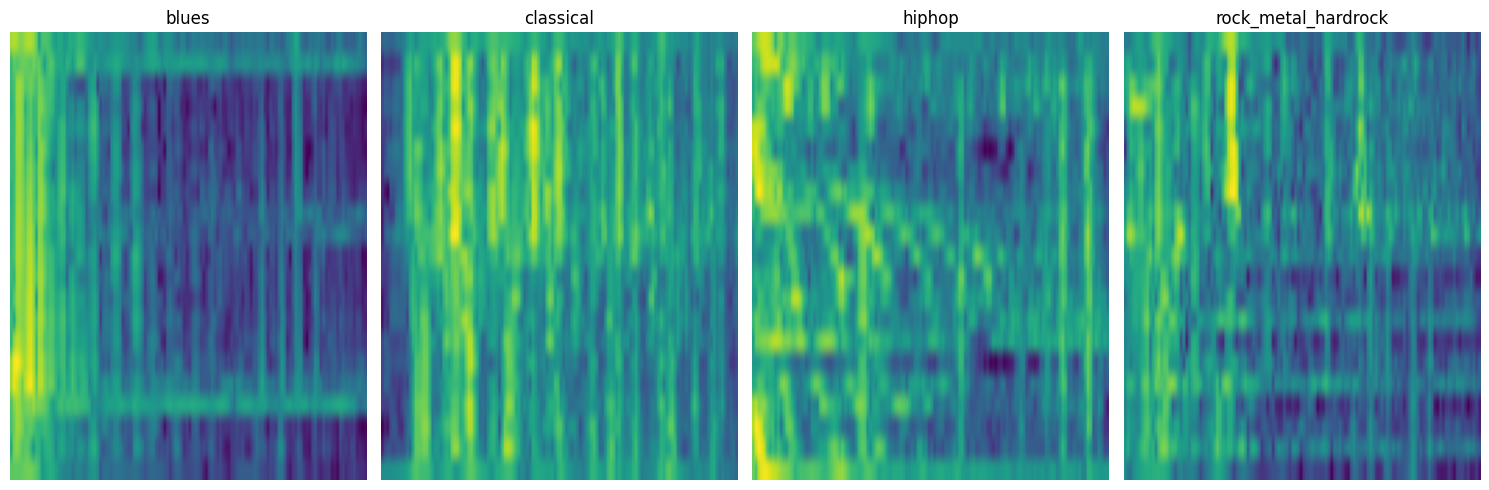

In [11]:
# Load the melgrams



X_train = np.load('/content/data/music_genre_data_di/train/melgrams/X.npy')
y_train = np.load('/content/data//music_genre_data_di/train/melgrams/labels.npy')

X_val = np.load('/content/data//music_genre_data_di/val/melgrams/X.npy')
y_val = np.load('/content/data//music_genre_data_di/val/melgrams/labels.npy')

X_test = np.load('/content/data//music_genre_data_di/test/melgrams/X.npy')
y_test = np.load('/content/data//music_genre_data_di/test/melgrams/labels.npy')

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train_enc = label_encoder.transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

int_to_label = {i: label for i, label in enumerate(label_encoder.classes_)}

unique_classes = np.unique(y_train)
plt.figure(figsize=(15, 5))

for i, genre in enumerate(unique_classes):
    idx = np.where(y_train == genre)[0][0]  # First occurrence of the genre
    melgram = X_train[idx]

    plt.subplot(1, len(unique_classes), i+1)
    plt.imshow(melgram, aspect='auto', origin='lower')
    plt.title(genre)
    plt.axis('off')

plt.tight_layout()
plt.show()



# CNN 2.2

In [12]:
class MelgramDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Wrap datasets
train_dataset = MelgramDataset(X_train, y_train_enc)
val_dataset = MelgramDataset(X_val, y_val_enc)
test_dataset = MelgramDataset(X_test, y_test_enc)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,worker_init_fn=seed_worker,generator=g)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True,worker_init_fn=seed_worker,generator=g)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False,worker_init_fn=seed_worker,generator=g)



In [13]:




class CNNClassifier(nn.Module):
    def __init__(self, input_shape):
        super(CNNClassifier, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5)

        # Compute output size after conv layers
        self._to_linear = None
        self._get_conv_output(input_shape)

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, 4)  # 4 output classes

    def _get_conv_output(self, shape):
        # Dummy forward pass to calculate output shape
        x = torch.zeros(1, 1, *shape)
        x = self.conv_forward(x)
        self._to_linear = x.view(1, -1).shape[1]

    def conv_forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

    def forward(self, x):
        x = self.conv_forward(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x


# CNN 2.3

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


input_shape = X_train.shape[1:]

model = CNNClassifier(input_shape).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.002)

start_time = time.time()

trained_model = train_model_with_validation(
    epochs=30,
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    device = device
)

end_time = time.time()
print(f"\nTraining time on {device}: {end_time - start_time:.2f} seconds")

val_loss, val_acc, val_f1, val_conf = evaluate_model(trained_model, val_loader, criterion,device)

print("\nValidation Results")
print(f"Loss       : {val_loss:.4f}")
print(f"Accuracy   : {val_acc:.4f}")
print(f"F1 (macro) : {val_f1:.4f}")
print("Confusion Matrix:\n", val_conf)





Epoch [1/30] | Train Loss: nan | Val Loss: nan | Val Acc: 0.2500 | Val F1: 0.1000
Epoch [2/30] | Train Loss: nan | Val Loss: nan | Val Acc: 0.2500 | Val F1: 0.1000
Epoch [3/30] | Train Loss: nan | Val Loss: nan | Val Acc: 0.2500 | Val F1: 0.1000
Epoch [4/30] | Train Loss: nan | Val Loss: nan | Val Acc: 0.2500 | Val F1: 0.1000
Epoch [5/30] | Train Loss: nan | Val Loss: nan | Val Acc: 0.2500 | Val F1: 0.1000
Epoch [6/30] | Train Loss: nan | Val Loss: nan | Val Acc: 0.2500 | Val F1: 0.1000
Epoch [7/30] | Train Loss: nan | Val Loss: nan | Val Acc: 0.2500 | Val F1: 0.1000
Epoch [8/30] | Train Loss: nan | Val Loss: nan | Val Acc: 0.2500 | Val F1: 0.1000
Epoch [9/30] | Train Loss: nan | Val Loss: nan | Val Acc: 0.2500 | Val F1: 0.1000
Epoch [10/30] | Train Loss: nan | Val Loss: nan | Val Acc: 0.2500 | Val F1: 0.1000
Epoch [11/30] | Train Loss: nan | Val Loss: nan | Val Acc: 0.2500 | Val F1: 0.1000
Epoch [12/30] | Train Loss: nan | Val Loss: nan | Val Acc: 0.2500 | Val F1: 0.1000
Epoch [13/30]

TypeError: evaluate_model() missing 1 required positional argument: 'device'

Το νέο δίκτυο φαίνεται να χρειάζεται σημαντικό χρόνο για να εκπαιδευτεί στην CPU, καθώς η εκτέλεση διακόπηκε στα 40 λεπτά για λόγους εξοικονόμησης χρόνου και πόρων. Αντίθετα, στην GPU φαίνεται πως δεν τρέχει σωστα αφόυ οι προβλέψεις του γίνονται στην τύχη.Στο απλό νευρωνικό δίκτυο, η CPU εμφανίζεται περίπου 1.5 φορά ταχύτερη από την GPU πιθανά λόγω της απλότητας του μοντέλου αφόυ στη cpu χρειάστηκε 6 δευτερόλεπτα ενώ στη gpu 8.

# CNN 2.4

In [15]:


class CNNClassifier(nn.Module):
    def __init__(self, input_shape):
        super(CNNClassifier, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self._to_linear = None
        self._get_conv_output(input_shape)

        self.fc1 = nn.Linear(self._to_linear, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, 4)

    def _get_conv_output(self, shape):
        x = torch.zeros(1, 1, *shape)
        x = self.conv_forward(x)
        self._to_linear = x.view(1, -1).shape[1]

    def conv_forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = self.pool4(self.conv4(x))
        return x

    def forward(self, x):
        x = self.conv_forward(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


input_shape = X_train.shape[1:]  # (128, 173) or whatever your mel-spectrogram shape is

model = CNNClassifier(input_shape).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.002)

start_time = time.time()

trained_model = train_model_with_validation(
    epochs=30,
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    device = device
)

end_time = time.time()
print(f"\nTraining time on {device}: {end_time - start_time:.2f} seconds")

val_loss, val_acc, val_f1, val_conf = evaluate_model(trained_model, val_loader, criterion,device)

print("\nValidation Results")
print(f"Loss       : {val_loss:.4f}")
print(f"Accuracy   : {val_acc:.4f}")
print(f"F1 (macro) : {val_f1:.4f}")
print("Confusion Matrix:\n", val_conf)





Epoch [1/30] | Train Loss: 1.3455 | Val Loss: 1.2906 | Val Acc: 0.4550 | Val F1: 0.3138
Epoch [2/30] | Train Loss: 1.2127 | Val Loss: 1.1700 | Val Acc: 0.4275 | Val F1: 0.3621
Epoch [3/30] | Train Loss: 1.0629 | Val Loss: 1.0067 | Val Acc: 0.5300 | Val F1: 0.4781
Epoch [4/30] | Train Loss: 0.9455 | Val Loss: 0.9328 | Val Acc: 0.5900 | Val F1: 0.5760
Epoch [5/30] | Train Loss: 0.8666 | Val Loss: 0.9450 | Val Acc: 0.5713 | Val F1: 0.5446
Epoch [6/30] | Train Loss: 0.8139 | Val Loss: 0.8582 | Val Acc: 0.6412 | Val F1: 0.6424
Epoch [7/30] | Train Loss: 0.7768 | Val Loss: 0.8854 | Val Acc: 0.6175 | Val F1: 0.5885
Epoch [8/30] | Train Loss: 0.7397 | Val Loss: 0.8254 | Val Acc: 0.6512 | Val F1: 0.6421
Epoch [9/30] | Train Loss: 0.7068 | Val Loss: 0.9066 | Val Acc: 0.6225 | Val F1: 0.5694
Epoch [10/30] | Train Loss: 0.6807 | Val Loss: 0.8259 | Val Acc: 0.6500 | Val F1: 0.6180
Epoch [11/30] | Train Loss: 0.6558 | Val Loss: 0.8536 | Val Acc: 0.6737 | Val F1: 0.6587
Epoch [12/30] | Train Loss: 0.

Η προσθήκη padding και max pooling βελτίωσε τόσο την ακρίβεια όσο και την αποδοτικότητα εκπαίδευσης του μοντέλου CNN. Το padding επέτρεψε στο δίκτυο να διατηρεί πληροφορία στις άκρες των εικόνων, ενώ το max pooling μείωσε τις υπολογιστικές απαιτήσεις, διατηρώντας ταυτόχρονα τα βασικά χαρακτηριστικά των εικόνων. Έτσι, το νέο δίκτυο εκπαιδεύτηκε στην gpu σε 41 δευτερόλεπτα σε σύγκριση με πριν όπου στην ίδια gpu το μοντέλο δεν κατάφερε να εκπαιδευτεί.

# CNN 2.5

In [17]:


class CNNClassifier(nn.Module):
    def __init__(self, input_shape):
        super(CNNClassifier, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self._to_linear = None
        self._get_conv_output(input_shape)

        self.fc1 = nn.Linear(self._to_linear, 1024)
        self.relu_fc1 = nn.ReLU()

        self.fc2 = nn.Linear(1024, 256)
        self.relu_fc2 = nn.ReLU()

        self.fc3 = nn.Linear(256, 32)
        self.relu_fc3 = nn.ReLU()

        self.fc4 = nn.Linear(32, 4)

    def _get_conv_output(self, shape):
        x = torch.zeros(1, 1, *shape)
        x = self.conv_forward(x)
        self._to_linear = x.view(1, -1).shape[1]

    def conv_forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        return x

    def forward(self, x):
        x = self.conv_forward(x)
        x = x.view(x.size(0), -1)
        x = self.relu_fc1(self.fc1(x))
        x = self.relu_fc2(self.fc2(x))
        x = self.relu_fc3(self.fc3(x))
        x = self.fc4(x)
        return x


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


input_shape = X_train.shape[1:]  # (128, 173) or whatever your mel-spectrogram shape is

model = CNNClassifier(input_shape).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.002)

start_time = time.time()

trained_model = train_model_with_validation(
    epochs=30,
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    device = device
)

end_time = time.time()
print(f"\nTraining time on {device}: {end_time - start_time:.2f} seconds")

val_loss, val_acc, val_f1, val_conf = evaluate_model(trained_model, val_loader, criterion,device)

print("\nValidation Results")
print(f"Loss       : {val_loss:.4f}")
print(f"Accuracy   : {val_acc:.4f}")
print(f"F1 (macro) : {val_f1:.4f}")
print("Confusion Matrix:\n", val_conf)





Epoch [1/30] | Train Loss: 1.3813 | Val Loss: 1.3716 | Val Acc: 0.2500 | Val F1: 0.1000
Epoch [2/30] | Train Loss: 1.3588 | Val Loss: 1.3574 | Val Acc: 0.2575 | Val F1: 0.1202
Epoch [3/30] | Train Loss: 1.3016 | Val Loss: 1.2982 | Val Acc: 0.3375 | Val F1: 0.2330
Epoch [4/30] | Train Loss: 1.2443 | Val Loss: 1.1940 | Val Acc: 0.4075 | Val F1: 0.2940
Epoch [5/30] | Train Loss: 1.1881 | Val Loss: 1.1905 | Val Acc: 0.4012 | Val F1: 0.3313
Epoch [6/30] | Train Loss: 1.1301 | Val Loss: 1.1360 | Val Acc: 0.4675 | Val F1: 0.4119
Epoch [7/30] | Train Loss: 1.0975 | Val Loss: 1.1302 | Val Acc: 0.4300 | Val F1: 0.3030
Epoch [8/30] | Train Loss: 1.0730 | Val Loss: 1.0552 | Val Acc: 0.4512 | Val F1: 0.3712
Epoch [9/30] | Train Loss: 1.0473 | Val Loss: 1.0419 | Val Acc: 0.4900 | Val F1: 0.4577
Epoch [10/30] | Train Loss: 1.0265 | Val Loss: 1.0399 | Val Acc: 0.4813 | Val F1: 0.4399
Epoch [11/30] | Train Loss: 1.0082 | Val Loss: 1.0220 | Val Acc: 0.5450 | Val F1: 0.5463
Epoch [12/30] | Train Loss: 0.

Η εισαγωγή της συνάρτησης ενεργοποίησης ReLU στο μοντέλο μας οδήγησε σε μείωση του F1 από 75% σε 68%. Αυτό μπορεί να αποδοθεί στην αύξηση της πολυπλοκότητας του μοντέλου και στην ανάγκη επαναρύθμισης των υπερπαραμέτρων εκπαίδευσης. Παράλληλα, παρατηρήθηκε πιο σταδιακή βελτίωση της απόδοσης κατά την εκπαίδευση, κάτι που σχετίζεται με τη μη γραμμικότητα της ReLU και τη διαφορετική δυναμική μάθησης που εισάγει στο δίκτυο.

# Performance Improving 3.2

In [19]:


# List of optimizers to test
optimizers_to_test = {
    "SGD": lambda model: optim.SGD(model.parameters(), lr=0.002),
    "Adam": lambda model: optim.Adam(model.parameters(), lr=0.002),
    "AdamW": lambda model: optim.Adam(model.parameters(), lr=0.002),
    "RMSprop": lambda model: optim.RMSprop(model.parameters(), lr=0.002),
    "Adagrad": lambda model: optim.Adagrad(model.parameters(), lr=0.002)
}

# Collect results
results = []
input_shape = X_train.shape[1:]  # (128, 173) or whatever your mel-spectrogram shape is


for name, optimizer_fn in optimizers_to_test.items():
    print("\n")
    # Reset the model
    model = CNNClassifier(input_shape).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_fn(model)

    # Train model
    trained_model = train_model_with_validation(
        epochs=30,
        model=model,
        optimizer=optimizer,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        device = device
    )

    # Evaluate model
    val_loss, val_acc, val_f1, val_conf = evaluate_model(trained_model, val_loader, criterion,device)

    # Save results
    results.append({
        "Optimizer": name,
        "Accuracy": round(val_acc, 4),
        "F1 Score": round(val_f1, 4)
    })

# Print results as a table
df_results = pd.DataFrame(results)
print("\nSummary of Optimizers:")
print(df_results)




Epoch [1/30] | Train Loss: 1.3761 | Val Loss: 1.3657 | Val Acc: 0.2712 | Val F1: 0.1404
Epoch [2/30] | Train Loss: 1.3631 | Val Loss: 1.3497 | Val Acc: 0.3375 | Val F1: 0.2327
Epoch [3/30] | Train Loss: 1.3303 | Val Loss: 1.3053 | Val Acc: 0.3638 | Val F1: 0.2718
Epoch [4/30] | Train Loss: 1.2632 | Val Loss: 1.2190 | Val Acc: 0.4012 | Val F1: 0.2858
Epoch [5/30] | Train Loss: 1.2181 | Val Loss: 1.1671 | Val Acc: 0.4412 | Val F1: 0.3800
Epoch [6/30] | Train Loss: 1.1774 | Val Loss: 1.1632 | Val Acc: 0.4963 | Val F1: 0.4811
Epoch [7/30] | Train Loss: 1.1398 | Val Loss: 1.1024 | Val Acc: 0.5188 | Val F1: 0.5076
Epoch [8/30] | Train Loss: 1.0888 | Val Loss: 1.1597 | Val Acc: 0.4275 | Val F1: 0.3925
Epoch [9/30] | Train Loss: 1.0523 | Val Loss: 1.0806 | Val Acc: 0.5125 | Val F1: 0.5082
Epoch [10/30] | Train Loss: 1.0317 | Val Loss: 1.0593 | Val Acc: 0.5262 | Val F1: 0.5018
Epoch [11/30] | Train Loss: 1.0108 | Val Loss: 1.0677 | Val Acc: 0.5050 | Val F1: 0.4562
Epoch [12/30] | Train Loss: 

In [20]:
# Print results as a table
df_results = pd.DataFrame(results)
print("\nSummary of Optimizers:")
print(df_results)


Summary of Optimizers:
  Optimizer  Accuracy  F1 Score
0       SGD    0.7238    0.7179
1      Adam    0.6937    0.6928
2     AdamW    0.7488    0.7480
3   RMSprop    0.7350    0.7387
4   Adagrad    0.7675    0.7668


Από τα αποτελέσματα, παρατηρούμε ότι ο Adagrad πέτυχε την υψηλότερη ακρίβεια (0.7675) και το καλύτερο F1 score (0.7668), υποδηλώνοντας την καλύτερη συνολική απόδοση. Ο AdamW ακολούθησε με πολύ καλή απόδοση, με ακρίβεια 0.7488 και F1 score 0.7480, δείχνοντας σταθερή συμπεριφορά. Ακολούθησε, ο RMSprop με απόδοση (ακρίβεια 0.7350 και F1 score 0.7387). Ο SGD και ο AdamW είχαν λιγο χειρότερα αποτελέσματα. Συμπερασματικά, ο Adagrad φαίνεται να προσφέρει την καλύτερη ισορροπία μεταξύ ακρίβειας και F1 score για το συγκεκριμένο dataset και πρόβλημα ταξινόμησης.


# Performance Improving 3.3

In [21]:

class CNNClassifier(nn.Module):
    def __init__(self, input_shape):
        super(CNNClassifier, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self._to_linear = None
        self._get_conv_output(input_shape)

        self.fc1 = nn.Linear(self._to_linear, 1024)
        self.relu_fc1 = nn.ReLU()

        self.fc2 = nn.Linear(1024, 256)
        self.relu_fc2 = nn.ReLU()

        self.fc3 = nn.Linear(256, 32)
        self.relu_fc3 = nn.ReLU()

        self.fc4 = nn.Linear(32, 4)

    def _get_conv_output(self, shape):
        x = torch.zeros(1, 1, *shape)
        x = self.conv_forward(x)
        self._to_linear = x.view(1, -1).shape[1]

    def conv_forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
        return x

    def forward(self, x):
        x = self.conv_forward(x)
        x = x.view(x.size(0), -1)
        x = self.relu_fc1(self.fc1(x))
        x = self.relu_fc2(self.fc2(x))
        x = self.relu_fc3(self.fc3(x))
        x = self.fc4(x)
        return x


In [27]:
#model without weight decay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


input_shape = X_train.shape[1:]  # (128, 173) or whatever your mel-spectrogram shape is

model = CNNClassifier(input_shape).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002)

start_time = time.time()

trained_model = train_model_with_validation(
    epochs=60,
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    device = device
)

end_time = time.time()
print(f"\nTraining time on {device}: {end_time - start_time:.2f} seconds")

val_loss, val_acc, val_f1, val_conf = evaluate_model(trained_model, val_loader, criterion,device)

print("\nValidation Results")
print(f"Loss       : {val_loss:.4f}")
print(f"Accuracy   : {val_acc:.4f}")
print(f"F1 (macro) : {val_f1:.4f}")
print("Confusion Matrix:\n", val_conf)

test_loss, test_acc, test_f1, test_conf = evaluate_model(trained_model, test_loader, criterion,device)

print("\nTest Results")
print(f"Loss       : {test_loss:.4f}")
print(f"Accuracy   : {test_acc:.4f}")
print(f"F1 (macro) : {test_f1:.4f}")
print("Confusion Matrix:\n", test_conf)






Epoch [1/60] | Train Loss: 0.9012 | Val Loss: 0.6406 | Val Acc: 0.7562 | Val F1: 0.7526
Epoch [2/60] | Train Loss: 0.6479 | Val Loss: 0.6114 | Val Acc: 0.7600 | Val F1: 0.7595
Epoch [3/60] | Train Loss: 0.5762 | Val Loss: 0.5679 | Val Acc: 0.7825 | Val F1: 0.7789
Epoch [4/60] | Train Loss: 0.5174 | Val Loss: 0.5694 | Val Acc: 0.7738 | Val F1: 0.7757
Epoch [5/60] | Train Loss: 0.4747 | Val Loss: 0.5287 | Val Acc: 0.8025 | Val F1: 0.8026
Epoch [6/60] | Train Loss: 0.4313 | Val Loss: 0.6785 | Val Acc: 0.7475 | Val F1: 0.7463
Epoch [7/60] | Train Loss: 0.3933 | Val Loss: 0.5303 | Val Acc: 0.7950 | Val F1: 0.7961
Epoch [8/60] | Train Loss: 0.3356 | Val Loss: 0.5847 | Val Acc: 0.7900 | Val F1: 0.7908
Epoch [9/60] | Train Loss: 0.3203 | Val Loss: 0.6629 | Val Acc: 0.7788 | Val F1: 0.7644
Epoch [10/60] | Train Loss: 0.2799 | Val Loss: 0.7001 | Val Acc: 0.7575 | Val F1: 0.7392
Epoch [11/60] | Train Loss: 0.2453 | Val Loss: 0.6402 | Val Acc: 0.7987 | Val F1: 0.7961
Epoch [12/60] | Train Loss: 0.

# Performance Improving 3.4

In [43]:
#Model with weight decay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


input_shape = X_train.shape[1:]  # (128, 173) or whatever your mel-spectrogram shape is

model = CNNClassifier(input_shape).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002,weight_decay=1e-5)

start_time = time.time()

trained_model = train_model_with_validation(
    epochs=60,
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    device=device
)

end_time = time.time()
print(f"\nTraining time on {device}: {end_time - start_time:.2f} seconds")

val_loss, val_acc, val_f1, val_conf = evaluate_model(trained_model, val_loader, criterion,device)

print("\nValidation Results")
print(f"Loss       : {val_loss:.4f}")
print(f"Accuracy   : {val_acc:.4f}")
print(f"F1 (macro) : {val_f1:.4f}")
print("Confusion Matrix:\n", val_conf)


test_loss, test_acc, test_f1, test_conf = evaluate_model(trained_model, test_loader, criterion,device)

print("\nTest Results")
print(f"Loss       : {test_loss:.4f}")
print(f"Accuracy   : {test_acc:.4f}")
print(f"F1 (macro) : {test_f1:.4f}")
print("Confusion Matrix:\n", test_conf)





Epoch [1/60] | Train Loss: 0.9839 | Val Loss: 0.6731 | Val Acc: 0.7500 | Val F1: 0.7431
Epoch [2/60] | Train Loss: 0.6989 | Val Loss: 0.7155 | Val Acc: 0.6900 | Val F1: 0.6777
Epoch [3/60] | Train Loss: 0.6068 | Val Loss: 0.6647 | Val Acc: 0.7375 | Val F1: 0.7342
Epoch [4/60] | Train Loss: 0.5620 | Val Loss: 0.6078 | Val Acc: 0.7575 | Val F1: 0.7614
Epoch [5/60] | Train Loss: 0.5092 | Val Loss: 0.5811 | Val Acc: 0.7750 | Val F1: 0.7727
Epoch [6/60] | Train Loss: 0.4772 | Val Loss: 0.5565 | Val Acc: 0.8063 | Val F1: 0.8050
Epoch [7/60] | Train Loss: 0.4329 | Val Loss: 0.5877 | Val Acc: 0.7975 | Val F1: 0.7895
Epoch [8/60] | Train Loss: 0.4117 | Val Loss: 0.5623 | Val Acc: 0.7837 | Val F1: 0.7786
Epoch [9/60] | Train Loss: 0.3731 | Val Loss: 0.6197 | Val Acc: 0.7688 | Val F1: 0.7729
Epoch [10/60] | Train Loss: 0.3535 | Val Loss: 0.5567 | Val Acc: 0.8075 | Val F1: 0.8060
Epoch [11/60] | Train Loss: 0.3041 | Val Loss: 0.6394 | Val Acc: 0.7887 | Val F1: 0.7874
Epoch [12/60] | Train Loss: 0.

In [42]:
#dropout added

class CNNClassifier(nn.Module):
    def __init__(self, input_shape, dropout_prob=0.3):
        super(CNNClassifier, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self._to_linear = None
        self._get_conv_output(input_shape)

        self.fc1 = nn.Linear(self._to_linear, 1024)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.relu_fc1 = nn.ReLU()

        self.fc2 = nn.Linear(1024, 256)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.relu_fc2 = nn.ReLU()

        self.fc3 = nn.Linear(256, 32)
        self.dropout3 = nn.Dropout(dropout_prob)
        self.relu_fc3 = nn.ReLU()

        self.fc4 = nn.Linear(32, 4)

    def _get_conv_output(self, shape):
        x = torch.zeros(1, 1, *shape)
        x = self.conv_forward(x)
        self._to_linear = x.view(1, -1).shape[1]

    def conv_forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
        return x

    def forward(self, x):
        x = self.conv_forward(x)
        x = x.view(x.size(0), -1)
        x = self.relu_fc1(self.dropout1(self.fc1(x)))
        x = self.relu_fc2(self.dropout2(self.fc2(x)))
        x = self.relu_fc3(self.dropout3(self.fc3(x)))
        x = self.fc4(x)
        return x


# Testing 4

In [44]:
import numpy as np

melgrams = np.load("/content/youtube_melgrams(1).npy", allow_pickle=True)
print(f"Loaded melgrams with shape: {melgrams.shape}")



Loaded melgrams with shape: (313, 21, 128)


In [45]:
# Load your melgrams from .npy file (shape should be (num_segments, 21, 128))
melgrams = np.load("/content/youtube_melgrams(1).npy", allow_pickle=True)

# Create dummy labels (e.g. zeros), since Dataset expects y_labels
dummy_labels = np.zeros(len(melgrams))

# Wrap your melgrams with the MelgramDataset (adds channel dimension and tensor conversion)
dataset = MelgramDataset(melgrams, dummy_labels)

# Use a DataLoader with batch size 1 (or more if you want)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)


In [46]:
def make_predictions(model, dataloader, device):
    model.eval()

    predictions = []

    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)  # if using GPU
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            predictions.append(preds.item())

    # Now you have predictions per melgram segment
    return predictions





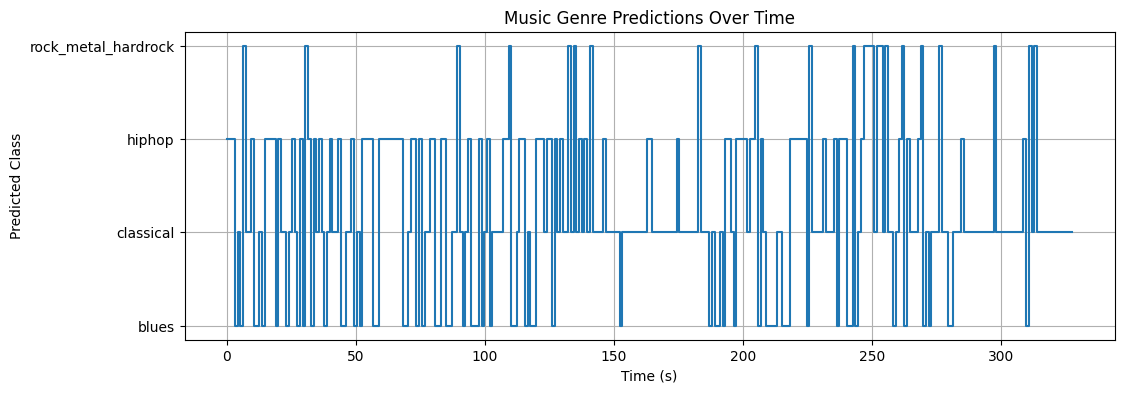

In [47]:


predictions = make_predictions(model,dataloader,device)


# Map prediction indices to string labels
predicted_labels = [int_to_label[int(pred)] for pred in predictions]

# For plotting, convert labels back to integers (0,1,2,3) so matplotlib can handle y-axis,
# but set the tick labels to class names
unique_labels = sorted(int_to_label.keys())
class_names = [int_to_label[i] for i in unique_labels]



segment_duration = 21 * 0.05
time_stamps = np.arange(len(predictions)) * segment_duration

plt.figure(figsize=(12, 4))
plt.step(time_stamps, predictions, where='post')

plt.yticks(ticks=unique_labels, labels=class_names)
plt.xlabel('Time (s)')
plt.ylabel('Predicted Class')
plt.title('Music Genre Predictions Over Time')
plt.grid(True)
plt.show()



Για την δοκιμή των προβλέψεων κατέβασα στο δοσμένο ipynb το ακόλουθο url:https://www.youtube.com/watch?v=l45f28PzfCI το οποίο ανήκει στην κλάση των blues.Το μοντέλο φαίνεται κατά διαστήματα να πραγματοποιεί σωστές προβλέψεις ενώ σε αρκετά σημεία μοιάζει να μπερδεύεται με την κλαση pop ή αυτην των classical.Σε γενικές γραμμές το μοντέλο δεν μοιάζει να έχει πολύ αυτοπεποίθηση για το συγκεκριμένο κομμάτι.